In [2]:
import keras
import tensorflow as tf
import os
import cv2 
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav

from numpy.lib import stride_tricks
from scipy import signal

## AVE-Net creation

In [3]:
Video_input_size = (224, 224, 3)
Audio_input_size = (257, 200, 1) 

In [4]:
#Vision subnetwork
Video_input = keras.layers.Input(shape=Video_input_size, name='Video_input')

video_conv_1_1 = keras.layers.Conv2D(64, (3, 3), activation='relu', strides=(2,2))(Video_input)
video_conv_1_1 = keras.layers.BatchNormalization()(video_conv_1_1)
video_conv_1_2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(video_conv_1_1)
video_conv_1_2 = keras.layers.BatchNormalization()(video_conv_1_2)
video_pool1    = keras.layers.MaxPool2D((2, 2), strides = (2,2))(video_conv_1_2)

video_conv_2_1 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(video_pool1)
video_conv_2_1 = keras.layers.BatchNormalization()(video_conv_2_1)
video_conv_2_2 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(video_conv_2_1)
video_conv_2_2 = keras.layers.BatchNormalization()(video_conv_2_2)
video_pool2   = keras.layers.MaxPool2D((2, 2), strides = (2,2))(video_conv_2_2)

video_conv_3_1 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(video_pool2)
video_conv_3_1 = keras.layers.BatchNormalization()(video_conv_3_1)
video_conv_3_2 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(video_conv_3_1)
video_conv_3_2 = keras.layers.BatchNormalization()(video_conv_3_2)
video_pool3   = keras.layers.MaxPool2D((2, 2), strides = (2,2))(video_conv_3_2)

video_conv_4_1 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(video_pool3)
video_conv_4_1 = keras.layers.BatchNormalization()(video_conv_4_1)
video_conv_4_2 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(video_conv_4_1)
video_conv_4_2 = keras.layers.BatchNormalization()(video_conv_4_2)
video_pool4   = keras.layers.MaxPool2D((13, 13), strides = (13,13))(video_conv_4_2)

video_fc1 = keras.layers.Dense(512, activation='relu')(video_pool4) #<----Dimensiones editadas por cuestiones de gpu 
video_fc2 = keras.layers.Dense(128)(video_fc1) #<----Dimensiones editadas por cuestiones de gpu 

visual_subnetwork = keras.models.Model(inputs=Video_input, outputs=video_fc2)

In [5]:
#Audio subnetowrk
Audio_input = keras.layers.Input(shape=Audio_input_size, name='Audio_input')

audio_conv_1_1 = keras.layers.Conv2D(64, (3, 3), activation='relu', strides=(2,2))(Audio_input)
audio_conv_1_1 = keras.layers.BatchNormalization()(audio_conv_1_1)
audio_conv_1_2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(audio_conv_1_1)
audio_conv_1_2 = keras.layers.BatchNormalization()(audio_conv_1_2)
audio_pool1    = keras.layers.MaxPool2D((2, 2), strides = (2,2))(audio_conv_1_2)

audio_conv_2_1 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(audio_pool1)
audio_conv_2_1 = keras.layers.BatchNormalization()(audio_conv_2_1)
audio_conv_2_2 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(audio_conv_2_1)
audio_conv_2_2 = keras.layers.BatchNormalization()(audio_conv_2_2)
audio_pool2   = keras.layers.MaxPool2D((2, 2), strides = (2,2))(audio_conv_2_2)

audio_conv_3_1 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(audio_pool2)
audio_conv_3_1 = keras.layers.BatchNormalization()(audio_conv_3_1)
audio_conv_3_2 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(audio_conv_3_1)
audio_conv_3_2 = keras.layers.BatchNormalization()(audio_conv_3_2)
audio_pool3   = keras.layers.MaxPool2D((2, 2), strides = (2,2))(audio_conv_3_2)

audio_conv_4_1 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(audio_pool3)
audio_conv_4_1 = keras.layers.BatchNormalization()(audio_conv_4_1)
audio_conv_4_2 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(audio_conv_4_1)
audio_conv_4_2 = keras.layers.BatchNormalization()(audio_conv_4_2)
audio_pool4   = keras.layers.MaxPool2D((12, 12), strides = (12,12))(audio_conv_4_2)

audio_fc1 = keras.layers.Dense(units=512, activation='relu')(audio_pool4) #<----Dimensiones editadas por cuestiones de gpu 
audio_fc2 = keras.layers.Dense(units=128)(audio_fc1) #<----Dimensiones editadas por cuestiones de gpu 

audio_subnetwork = keras.models.Model(inputs=Audio_input, outputs=audio_fc2)

In [6]:
visual_subnetwork.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Video_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 111, 111, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 111, 111, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 111, 111, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 111, 111, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 55, 55, 128)       73856 

In [7]:
audio_subnetwork.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Audio_input (InputLayer)     [(None, 257, 200, 1)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 99, 64)       640       
_________________________________________________________________
batch_normalization_8 (Batch (None, 128, 99, 64)       256       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 99, 64)       36928     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128, 99, 64)       256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 49, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 49, 128)       7385

In [8]:
#AVE-Net
euclidean_distance = tf.norm(tf.nn.l2_normalize(video_fc2, 0)-tf.nn.l2_normalize(audio_fc2, 0),ord='euclidean',axis=3)
fc3 = keras.layers.Dense(units=2, activation='softmax')(euclidean_distance)

AVE_Net = keras.models.Model(inputs=[Video_input, Audio_input], outputs=fc3)

In [9]:
AVE_Net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Video_input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Audio_input (InputLayer)        [(None, 257, 200, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 64) 1792        Video_input[0][0]                
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 128, 99, 64)  640         Audio_input[0][0]                
____________________________________________________________________________________________

## Preparate data from training

In [10]:
train_segments = pd.read_csv('csv/unbalanced_train_segments_implementation.csv').values

In [11]:
videos = os.listdir('Video')

In [12]:
train_frames = []
train_audio  = []
target = []

time = 0.5
start = int(time*48000)-24000
end   = int(time*48000)+24000

for video_index, video_name in enumerate(videos):
    audio_name = 'audio_' + video_name[6:-4] + '.wav'
    #Image processing
    capturedVideo = cv2.VideoCapture('Video/'+videos[video_index])
    have_frames = True
    frames = []

    while have_frames:
        have_frames, frame = capturedVideo.read()

        if have_frames == True:
            frames.append(frame)
    middle = int(len(frames)/2)
    #Audio processing
    sample_rate, samples = wav.read('Audio/' + audio_name)
    frequencies, times, spectrogram = signal.spectrogram(samples[start:end], sample_rate, nperseg=512, noverlap=274)

    target.append(0)
    train_audio.append(np.log(spectrogram))
    train_frames.append(cv2.resize(cv2.cvtColor(frames[middle], cv2.COLOR_BGR2RGB),(Video_input_size[0],Video_input_size[1])))
    capturedVideo.release()

print('np.shape(train_frames):',np.shape(train_frames))
print('np.shape(train_audio):',np.shape(train_audio))

np.shape(train_frames): (514, 224, 224, 3)
np.shape(train_audio): (514, 257, 200)


In [13]:
train_frames = np.array(train_frames)
target = np.array(target)
middle = int(train_frames.shape[0]/2)
random.shuffle(train_frames[middle:,:,:,:])

target[middle:] = 1
target = tf.keras.utils.to_categorical(target)
target = np.expand_dims(target,axis=1)

print('np.shape(target):',np.shape(target))

np.shape(target): (514, 1, 2)


In [14]:
a = np.array([1,2,3,4,5,6,7,8,9,10])
random.shuffle(a[5:])
a

array([ 1,  2,  3,  4,  5, 10,  9,  8,  7,  6])

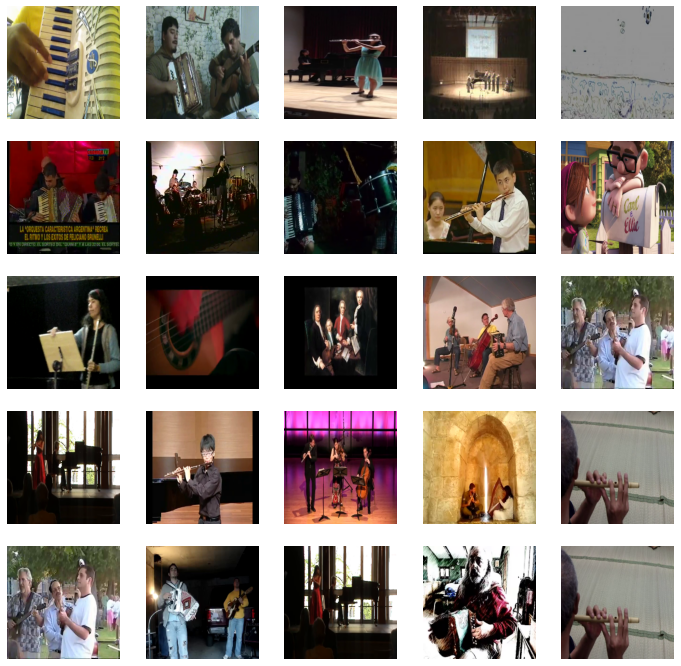

In [15]:
plt.figure(figsize=(12,12))
for i in range(25):

    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow(train_frames[np.random.randint(len(train_frames)/2, len(train_frames))])

In [16]:
plt.figure(figsize=(12,12))
for i in range(25):

    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow(train_audio[np.random.randint(len(train_audio))])

In [18]:
AVE_Net.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
AVE_Net.fit([np.array(train_frames), np.array(train_audio)], np.array(target),verbose=1, epochs=20)  

Epoch 1/20
17/17 [==============================] - 9s 518ms/step - loss: 0.6936 - accuracy: 0.5136
Epoch 2/20
17/17 [==============================] - 9s 522ms/step - loss: 0.7120 - accuracy: 0.5000
Epoch 3/20
17/17 [==============================] - 9s 523ms/step - loss: 0.7053 - accuracy: 0.5000
Epoch 4/20
17/17 [==============================] - 9s 521ms/step - loss: 0.6961 - accuracy: 0.5000
Epoch 5/20
17/17 [==============================] - 9s 522ms/step - loss: 0.6859 - accuracy: 0.5389
Epoch 6/20
17/17 [==============================] - 9s 520ms/step - loss: 0.6879 - accuracy: 0.5039
Epoch 7/20
17/17 [==============================] - 9s 522ms/step - loss: 0.6870 - accuracy: 0.5000
Epoch 8/20
17/17 [==============================] - 9s 522ms/step - loss: 0.6914 - accuracy: 0.5000
Epoch 9/20
17/17 [==============================] - 9s 520ms/step - loss: 0.6841 - accuracy: 0.5292
Epoch 10/20
17/17 [==============================] - 9s 519ms/step - loss: 0.6705 - accuracy: 0.5700